In [1]:
import pennylane as qml
import numpy as np
from pprint import pprint 
import matplotlib.pyplot as plt

dev = qml.device("default.qubit",wires=4,shots=1000)

@qml.qnode(dev)
def f2():
    qml.Hadamard(0)
    qml.CNOT([0, 1])
    qml.CNOT([1, 2])

    m0 = qml.measure(0)
    m1 = qml.measure(1)

    qml.cond(m0 + m1 == 2, qml.CNOT)([1, 2])
    return qml.expval(qml.PauliZ(2))
print('f2=%.2f'%f2())
print(qml.draw(f2)())

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k
OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


f2=1.00
0: ──H─╭●─────┤↗├─────────┤     
1: ────╰X─╭●───║───┤↗├─╭●─┤     
2: ───────╰X───║────║──╰X─┤  <Z>
               ╚════║═══╣       
                    ╚═══╝       


In [2]:
nInp = 3
nSamp=300
X=np.random.uniform(-0.99,0.99,size=(nInp,nSamp))
#X[:,0]=[0]*nInp  # to repeat ???
Xang=np.arccos(X)
shots=100
nWires=nInp+1
wires=range(nWires)
dev = qml.device("default.qubit",wires=nWires,shots=shots)

In [34]:
# circuit:  3 input qubits, feed-forward sets 1 output qubits, which is measured
@qml.qnode(dev)
def f3(xang):
    ninp=xang.shape[0]
    qout=ninp
    mL=[None for i in range(ninp)]
    #.... set and measure input qubits
    for i in range(ninp):  
        qml.RX(xang[i],i)
        mL[i]=qml.measure(i)   
    hw=sum(mL)   #... compute hamming weights
    qml.cond(hw == 1, qml.PauliX)(qout)  # select 1 value of HW
    return qml.probs(ninp)

print(qml.draw(f3)(Xang[:,0]))
probs=f3(Xang)
print(X[:,0], np.mean(X[:,0])); pprint(probs[0])

0: ──RX(2.28)──┤↗├──────────────────────────────────┤       
1: ─────────────║───RX(1.92)──┤↗├───────────────────┤       
2: ─────────────║──────────────║───RX(1.64)──┤↗├────┤       
3: ─────────────║──────────────║──────────────║───X─┤  Probs
                ╚══════════════║══════════════║═══╣         
                               ╚══════════════║═══╣         
                                              ╚═══╝         
[-0.65452951 -0.34012094 -0.07353296] -0.3560611363330081
array([0.7914, 0.2086])


In [8]:
# decode output
Xavr=np.mean(X,axis=0)
pr1=probs[:,1]
print('Xavr:',Xavr.shape,pr1.shape)
for i in range(nSamp):
    pr=probs[i][1]
    print('i=',i,' xAvr:%.3f  pr=%.3f'%(Xavr[i],pr))
    if i>5: break

Xavr: (300,) (300,)
i= 0  xAvr:-0.356  pr=0.210
i= 1  xAvr:0.183  pr=0.360
i= 2  xAvr:0.455  pr=0.450
i= 3  xAvr:0.151  pr=0.480
i= 4  xAvr:0.091  pr=0.470
i= 5  xAvr:-0.388  pr=0.130
i= 6  xAvr:0.884  pr=0.130


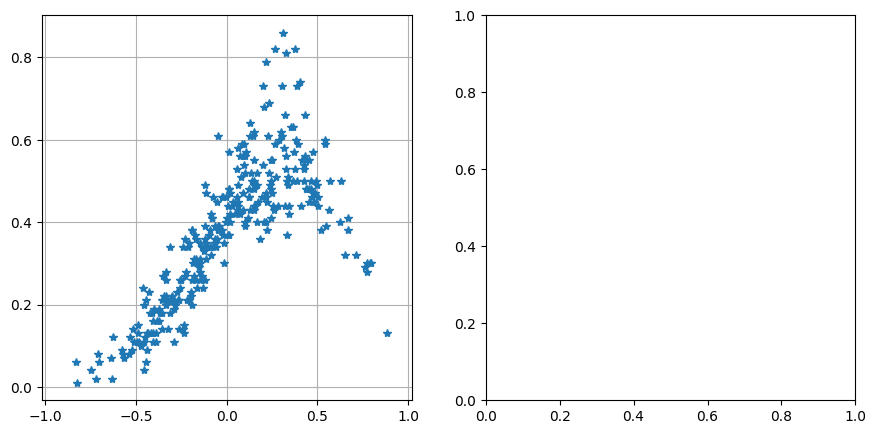

In [9]:
# plot losses and accuracies
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 5))
ax=axes[0]
ax.plot(Xavr,probs[:,1],"*")
ax.set_xlim(-1.02,1.02)
ax.grid()

#  TOY  for HW>thres, uses 3xH as input

In [10]:
dev = qml.device("default.qubit",wires=4,shots=1000)

@qml.qnode(dev)
def f4(tghw):
    ninp=3
    mL=[None for i in range(ninp)]
    #.... set and measure input qubits
    for i in range(ninp):  
        qml.Hadamard(i)
        mL[i]=qml.measure(i)
    #... compute hamming weights
    hw=sum(mL)
    qml.cond(hw >= tghw, qml.PauliX)(ninp)
    return qml.counts()

print(qml.draw(f4)(0))
pprint(f4(tghw=1))

0: ──H──┤↗├────────────────────┤  Counts
1: ──────║───H──┤↗├────────────┤  Counts
2: ──────║───────║───H──┤↗├────┤  Counts
3: ──────║───────║───────║───X─┤  Counts
         ╚═══════║═══════║═══╣    Counts
                 ╚═══════║═══╣    Counts
                         ╚═══╝    Counts
{'0000': tensor(124, requires_grad=True),
 '0011': tensor(131, requires_grad=True),
 '0101': tensor(132, requires_grad=True),
 '0111': tensor(133, requires_grad=True),
 '1001': tensor(116, requires_grad=True),
 '1011': tensor(124, requires_grad=True),
 '1101': tensor(105, requires_grad=True),
 '1111': tensor(135, requires_grad=True)}


### weighted HW  - from Tom 
https://discuss.pennylane.ai/t/feed-forward-on-ibm-hw-failure/3931/6

In [38]:
import pennylane as qml
from pprint import pprint
import numpy as np

dev = qml.device("default.qubit",wires=4,shots=8000)

@qml.qnode(dev)
def f5():
    ninp=3
    qout=ninp
    mL=[None for i in range(ninp)] # locks memory
    for i in range(ninp):  
        qml.Hadamard(i)
        mL[i]=qml.measure(i)        
    hw=sum(mL)
    pL=np.array([0.5, 0.7, 0.,  1.])
    angL=np.arccos(1-2*pL)
    [qml.cond(hw ==i,  qml.RX)(angL[i],qout) for i in range(ninp+1)]
    return qml.sample()

print(qml.draw(f5)())
samples = f5()
counts = qml.counts(wires=[0, 1, 2, 3])._samples_to_counts(samples)
pprint(counts)

0: ──H──┤↗├─────────────────────────────────────────────────────────┤  Sample
1: ──────║───H──┤↗├─────────────────────────────────────────────────┤  Sample
2: ──────║───────║───H──┤↗├─────────────────────────────────────────┤  Sample
3: ──────║───────║───────║───RX(1.57)──RX(1.98)──RX(0.00)──RX(3.14)─┤  Sample
         ╚═══════║═══════║═══╬═════════╬═════════╬═════════╣           Sample
                 ╚═══════║═══╬═════════╬═════════╬═════════╣           Sample
                         ╚═══╩═════════╩═════════╩═════════╝           Sample
{'0000': 497,
 '0001': 522,
 '0010': 322,
 '0011': 690,
 '0100': 308,
 '0101': 708,
 '0110': 994,
 '1000': 316,
 '1001': 694,
 '1010': 1016,
 '1100': 948,
 '1111': 985}


###  weighted average of multiple HammingWeights

In [60]:
# circuit:  3 input qubits, feed-forward sets 1 output qubits, which is measured
@qml.qnode(dev)
def f6(xang):
    ninp=xang.shape[0]
    qout=ninp
    mL=[None for i in range(ninp)]
    #.... set and measure input qubits
    for i in range(ninp):  
        qml.RX(xang[i],i)
        mL[i]=qml.measure(i)   
    hw=sum(mL)   #... compute hamming weights
    pL=np.array([1.0, 0.6, 0.2,  0.3])
    angL=np.arccos(1-2*pL)
    for i in range(ninp+1):
        qml.cond(hw ==i,  qml.RX)(angL[i],qout) 
    return qml.probs(qout)

print(qml.draw(f6)(Xang[:,0]))
probs=f6(Xang)
print(X[:,0], np.mean(X[:,0])); pprint(probs[0])

0: ──RX(2.28)──┤↗├───────────────────────────────────────────────────────────────────────┤       
1: ─────────────║───RX(1.92)──┤↗├────────────────────────────────────────────────────────┤       
2: ─────────────║──────────────║───RX(1.64)──┤↗├─────────────────────────────────────────┤       
3: ─────────────║──────────────║──────────────║───RX(3.14)──RX(1.77)──RX(0.93)──RX(1.16)─┤  Probs
                ╚══════════════║══════════════║═══╬═════════╬═════════╬═════════╣                
                               ╚══════════════║═══╬═════════╬═════════╬═════════╣                
                                              ╚═══╩═════════╩═════════╩═════════╝                
[-0.65452951 -0.34012094 -0.07353296] -0.3560611363330081
array([0.674375, 0.325625])


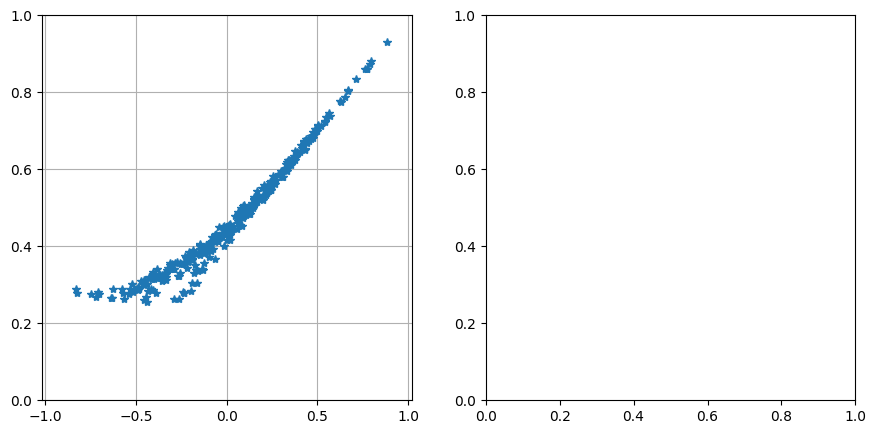

In [61]:
# plot losses and accuracies
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 5))
ax=axes[0]
ax.plot(Xavr,probs[:,1],"*")
ax.set_xlim(-1.02,1.02)
ax.set_ylim(0,1)
ax.grid()